# Detecting Breast Cancer

Invasive Ductal Carcinoma (IDC) is the most common subtype of breast cancer. In order to predict patient outcome, histopathologists determine IDC's agressiveness grade by analyzing whole slide histopathology images. The purpose of the histopathologist is to identify regions indicating the presence of cancerous tissue. This task is time consumming and prone to human error, then it would be helpful to develop an automized classifier capable of discriminating cancerous tissue from non-cancerous tissue in an image.

This kind of model would be helpfull for hospitals and medical laboratories to increase sample speed analysis and help doctors take decisions faster. Also this kind of automized classifier will free some of the histopathologist time so he can focus on more important task or more complex samples.

The curated data is obtained directly from [Kaggle.com](https://www.kaggle.com/paultimothymooney/breast-histopathology-images/data). It contains only whole slides color images divided by patient. Each whole slide image is segmented in patches of 50x50 pixels. Each of the patches corresponds either to an IDC region or a cancer free zone. Each image patch class is contained in its file name. The presence of IDC is indicated by a 1 while 0 corresponds to an IDC free area.

In [1]:
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


Checking GPU support:

In [2]:
import tensorflow as tf
# Checking GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


The data is divided in folders were each folder corresponds to a patient.

In [3]:
# Path to data
path = "./Data/IDC_regular_ps50_idx5"
# Identify data folders
folders = [folder for folder in os.listdir(path)]

print("Number of patients: %d" %len(folders))

Number of patients: 279


## Healthy tissue vs IDC tissue

As mentioned before, the class type for each 50x50 pixel image is indicated in its file name. The file name consists of three parts: a four digit number identifying the patient, a set of (x, y) coordinates corresponding to the region position in the whole slide, and finally the category class. The class can be either 0 or 1. 0 represents healthy tissue or absence of cancer while 1 corresponds to regions were IDC was found.

Healthy image shape: (50, 50, 3)
IDC image shape: (50, 50, 3)


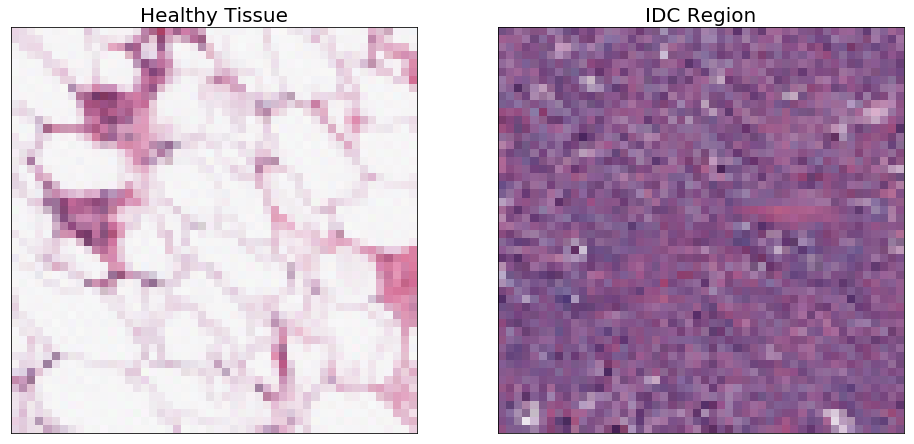

In [4]:
# Healthy image
img_0 = cv2.imread(path + '/' + '8863' + '/' + '0' + '/' + '8863_idx5_x351_y751_class0.png')
# IDC image
img_1 = cv2.imread(path + '/' + '8863' + '/' + '1' + '/' + '8863_idx5_x1051_y1601_class1.png')
# Convert to RGB
img_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
# Plot images
fig = plt.figure(figsize = (16,8))
# Healthy image
ax1 = fig.add_subplot(121)
ax1.imshow(img_0)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.title("Healthy Tissue", size = 20)
# IDC Image
ax2 = fig.add_subplot(122)
ax2.imshow(img_1)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.title("IDC Region", size = 20)
# Images shape
print("Healthy image shape: {}".format(img_0.shape))
print("IDC image shape: {}".format(img_1.shape))

IDC regions appear to be denser and have darkers tones of violet compared to healthy tissue. This information can be used to define features in order to train a machine learning model. However a literature [review](http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872) on this data set tells us that this not the best approach. A more reliable model uses CNN.

## Loading images

Images are 50x50x3 where the third dimension corresponds to RGB color coding. This information is important to take it into account when loading the images and defining the CNN architecture.

In [5]:
def path_to_tensor(img_path):
    # load images
    img = cv2.imread(img_path)
    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape == (50, 50, 3):
        # convert 3D tensor to 4D tensor with shape (1, 50, 50, 3) and return 4D tensor
        #return np.expand_dims(img, axis=0)
        return img.astype(np.float32) / 255
        #return img.reshape([50,50,3])

Each patient's folder contains two folders: a folder with non cancer images and a folder with cancerous tissue images.

In [6]:
# Healthy tissue is in folder 0 and cancerous tissue in folder 1
folder_label = ['0', '1']
images = [] # stores images
labels = [] # stores image leabels 

for folder in folders:
    # Read from folder 0 and create corresponding label array
    path_0 = path + '/' + folder + '/' + folder_label[0]
    images_0 = [path_to_tensor(path_0 + '/' + img_path) for img_path in os.listdir(path_0) \
               if path_to_tensor(path_0 + '/' + img_path) is not None]
    labels_0 = np.zeros(len(images_0), dtype=np.int8)
    images.extend(images_0)
    labels.extend(labels_0)
    # Read from folder 1 and create corresponding label array
    path_1 = path + '/' + folder + '/' + folder_label[1]
    images_1 = [path_to_tensor(path_1 + '/' + img_path) for img_path in os.listdir(path_1) \
               if path_to_tensor(path_1 + '/' + img_path) is not None]
    labels_1 = np.ones(len(images_1), dtype=np.int8)
    images.extend(images_1)
    labels.extend(labels_1)    

Number of images: 275222
Number of labels: 275222


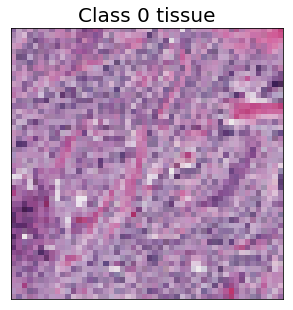

In [7]:
images = np.array(images)
labels = np.array(labels)

print("Number of images: {}".format(len(images)))
print("Number of labels: {}".format(len(labels)))

fig = plt.figure(figsize = (5,5))
_ = plt.imshow(images[0])
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.title("Class {} tissue".format(labels[0]), size = 20)

In [8]:
print("Number of 1 labels: {}".format(np.sum(labels)))
print("Number of 0 labels: {}".format(len(labels) - np.sum(labels)))

Number of 1 labels: 78768
Number of 0 labels: 196454


In this data set the classes are unbalanced with a ration of 2.5 to 1 in favor of label 0. So, in addition to the accuracy metric to assess the final model, it will be also important to check the F<sub>1</sub> score.

## Metrics definition

To assess the fitness of the developed model, it is important to know how many labels in the validation set are predicted correctly. So, the metric of choice to evaluate the model is the accuracy. The accuracy calculates the number of correct predicted labels to the total number of labels. To explain this with an equation let's define first the following terms:

TP: true positives, it represents the images correctly identified as 1, meaning an IDC region.

FP: false postives, it denotes the images of healthy tissue incorrectly indentified as 1.

TN: true negatives, it refers to healthy tissue images correctly identified as 0.

FN: false negatives, it defines IDC region images identified as 0 or being healthy.

With theses definitions at hand, the accuracy is defined as:

![Accuracy](https://latex.codecogs.com/gif.latex?Accuracy&space;=&space;\frac{TP&space;&plus;&space;TN}{TP&space;&plus;&space;TN&space;&plus;&space;FP&space;&plus;&space;FN})

In addition to the accuracy, given that the classes are unbalanced, a metric of interest is the F<sub>1</sub> score:

![F_1](https://latex.codecogs.com/gif.latex?F_1&space;=&space;\frac{2}{\frac{1}{Precision}&space;&plus;&space;\frac{1}{Recall}}&space;=&space;2\frac{Precision.Recall}{Precision&space;&plus;&space;Recall})

Where *Precision = TP/(TP+FP)* and *Recall=TP/(TP+FN)*.

Having determined the evaluation metrics, now it is important to define a benchmark model to assess the developed models. Given that the classes are unbalanced and that the negative classes dominates the positive classes, a model predicting that all the images correspond to a label of 0 is a good starting model.

## Bechmark model

Images of category 0 are more common than the images with class 1, the ratio being approximately 2.5 to 1. Given that the classes are unbalanced at the advantage of label 0, then we can define a naive bencmark model were all the images are labeled as 0. Doing so results in the following values.

In [9]:
TP = 0 # true positive
FP = 0 # false postive
TN = len(labels) - np.sum(labels) # true negative
FN = np.sum(labels) # false negative

print("True postives: {}".format(TP))
print("False postives: {}".format(FP))
print("True negatives: {}".format(TN))
print("False negatives: {}\n".format(FN))

accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: {:.2f}%\n".format(accuracy*100))

True postives: 0
False postives: 0
True negatives: 196454
False negatives: 78768

Accuracy: 71.38%



In [10]:
precision_neg = TN / (TN + FN)
print("Scores for healthy tissue images (negatives labels):")
print("\t\t Precision: {:.2f}%".format(precision_neg*100))
recall_neg = TN / (TN + FP)
print("\t\t Recall: {:.2f}%".format(recall_neg*100))
f1 = 2 / (1 / precision_neg + 1 / recall_neg)
print("\t\t F1 score: {:.2f}%".format(f1*100))

Scores for healthy tissue images (negatives labels):
		 Precision: 71.38%
		 Recall: 100.00%
		 F1 score: 83.30%


The benchmark model has then an accuracy of 71.38% and and F<sub>1</sub> score of 83.30% for the negaitve labels. An F<sub>1</sub> score for the postitve labels is undefined given that no positve images are detected under this model.

Having defined a benchmark model now we can proceed to develop a more reliable model.

# CNN Architectures

## Defining train and test sets

In order to train the models and determine how they behave, the images need to be divided in two: a training set and a validation set. In this case 90% of the images are held for training while 10% of them are assigned for testing.

Given that the classes are unbalanced, the 'stratify' parameter of the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method from scikit-learn is used.

In [13]:
from sklearn.model_selection import train_test_split

# Set seed for random calculations
seed = 42
np.random.seed(seed)
# SPlit between train and test set
idx_train, idx_test = train_test_split(np.arange(labels.shape[0]), test_size=0.1, \
                                      random_state=seed, shuffle=True, stratify=labels)

# Using an existing architecture: transfer learning

The first model and more direct approach to try consists in applying transfer learning. Transfer learning uses a pre-trained model to be applied in a new data set by introducing minor modifications. This method allows saving training time in otherwise highly time consuming models.

The CNN architecture [VGG19](https://arxiv.org/abs/1409.1556) is chosen given that it accepts images of 50x50 pixels and it has been shown to give good results on the [ImageNet](http://image-net.org/) data set. 

Our data set doesn't corresponds to images from ImageNet, however the pre-trained weights already now to recognize complex patterns in images, so its use may be useful to train our model.

ImageNet is a data set with 1000 categories, so in order to be able to use the pre-trained network, the last full connected layers are ignored and only the convolutional layers are imported.

In [17]:
from keras.applications.vgg19 import VGG19

In [18]:
model = VGG19(include_top=False, input_shape=(50,50,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

### Bottlenck Features

Now that the weights corresponding to VGG19 convolutional layers have been imported, the next step is to calculate the bottleneck features. The term bottleneck features refers to the output of the last convolutional layer when the train and test images are fed to the CNN network.

In [19]:
# Bottleneck features for training set
bottleneck_features_train = model.predict(images[idx_train])
np.save('./bottleneck_features/bottleneck_features_train_VGG19.npy', \
        bottleneck_features_train)
# Bottleneck features for test set
bottleneck_features_test = model.predict(images[idx_test])
np.save('./bottleneck_features/bottleneck_features_test_VGG19.npy', \
        bottleneck_features_test)

In [20]:
# Check shapes
bottleneck_features_train = np.load('./bottleneck_features/bottleneck_features_train_VGG19.npy')
print("Bottleneck train features shape: {}".format(bottleneck_features_train.shape))

bottleneck_features_test = np.load('./bottleneck_features/bottleneck_features_test_VGG19.npy')
print("Bottleneck train features shape: {}".format(bottleneck_features_test.shape))

Bottleneck train features shape: (247699, 1, 1, 512)
Bottleneck train features shape: (27523, 1, 1, 512)


Now that the bottleneck features have been calculated, it is possible to define a model architecture corresponding to the full connected layers that were dropped from VGG19.

The final output consists of one category which is the probability for an image to belong to class 1. The activation function for the last layer is the 'sigmoid' because its range is between 0 and 1.

In [143]:
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape= (1,1,512)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# Ouput layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 164,353
Trainable params: 164,353
Non-trainable params: 0
_________________________________________________________________


To train the model, advantage is taken from Keras callback methods. [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint) allows to save the weights corresponding to the best epoch. [EarlyStopping](https://keras.io/callbacks/#earlystopping) stops the training if the model loss doesn't improve after a determined number of epochs. These methods avoid training the model more than necessary and save the weights from the best loss found.

Given that the classes are not balanced, the parameter 'class_weight' from de [fit](https://keras.io/models/model/#fit) method is set to ${0:1, 1:2.5}$ in order to account for the difference ratio between 0 and 1 labels.

In [144]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

epochs = 100
batch_size = 256

stopping_condition = EarlyStopping(patience=6)
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.CNN_arch_VGG19.hdf5', \
                               verbose=1, save_best_only=True)

history = model.fit(bottleneck_features_train, labels[idx_train], \
          validation_split=0.2, \
          epochs=epochs, batch_size=batch_size, class_weight={0:1, 1:2.5},\
          callbacks=[checkpointer, stopping_condition], verbose=1)

Train on 198159 samples, validate on 49540 samples
Epoch 1/100
198159/198159 [==============================] - 2s 12us/step - loss: 0.7613 - acc: 0.7479 - val_loss: 0.6919 - val_acc: 0.7836

Epoch 00001: val_loss improved from inf to 0.69188, saving model to ./saved_models/weights.best.CNN_arch_VGG19.hdf5
Epoch 2/100
198159/198159 [==============================] - 2s 10us/step - loss: 0.7264 - acc: 0.7678 - val_loss: 0.6859 - val_acc: 0.7739

Epoch 00002: val_loss improved from 0.69188 to 0.68588, saving model to ./saved_models/weights.best.CNN_arch_VGG19.hdf5
Epoch 3/100
198159/198159 [==============================] - 2s 9us/step - loss: 0.7161 - acc: 0.7712 - val_loss: 0.6772 - val_acc: 0.7960

Epoch 00003: val_loss improved from 0.68588 to 0.67719, saving model to ./saved_models/weights.best.CNN_arch_VGG19.hdf5
Epoch 4/100
198159/198159 [==============================] - 2s 10us/step - loss: 0.7085 - acc: 0.7746 - val_loss: 0.6689 - val_acc: 0.7895

Epoch 00004: val_loss improved

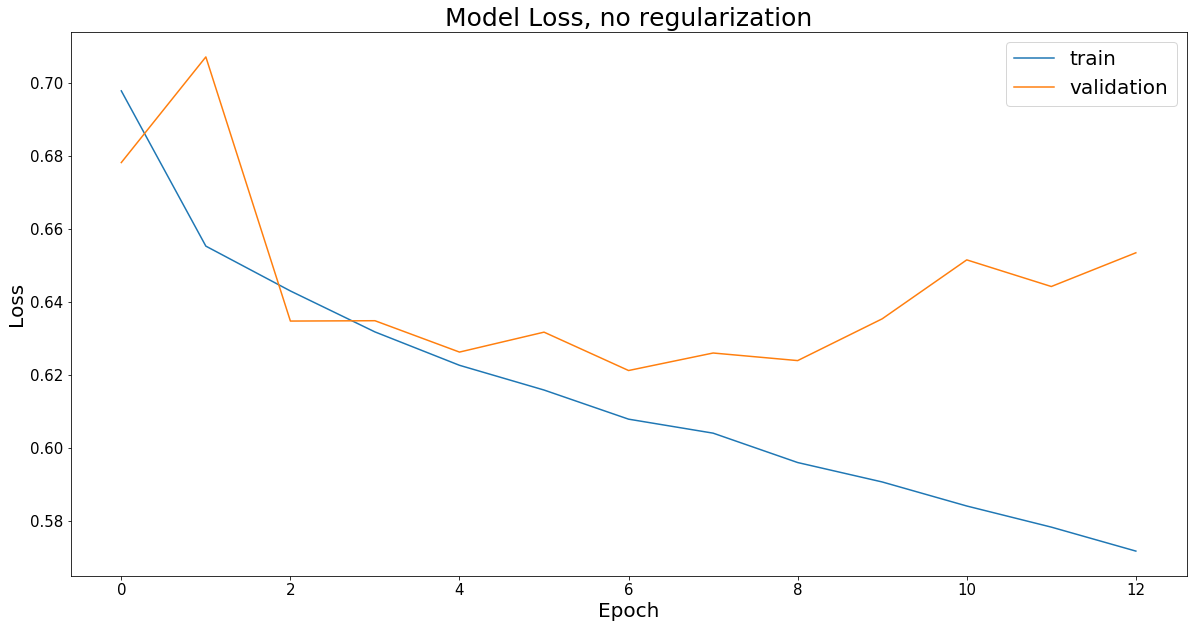

In [139]:
# Visualize the training and validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(size=15)
plt.ylabel('Loss', size=20)
plt.xticks(size=15)
plt.xlabel('Epoch', size=20)
plt.legend(['train', 'validation'], loc='upper right', fontsize=20)
plt.title('Model Loss, no regularization', size=25)
plt.show()
# test accuracy 80.4164%

The plot above shows the train and validation losses behavior as the model trains. In this particular case regularization was not applied. In other words, [Dropout](https://keras.io/layers/core/#dropout) layers were not applied. With no regularization, the curve shows overfitting: the loss improves on the training set but diverges on the validation set as the number of epochs increases. The accuracy on the test set is about 80.4164%.

The overfitting indication tells us that we need to apply regularization to the model. Below the model training beahvior is shown).

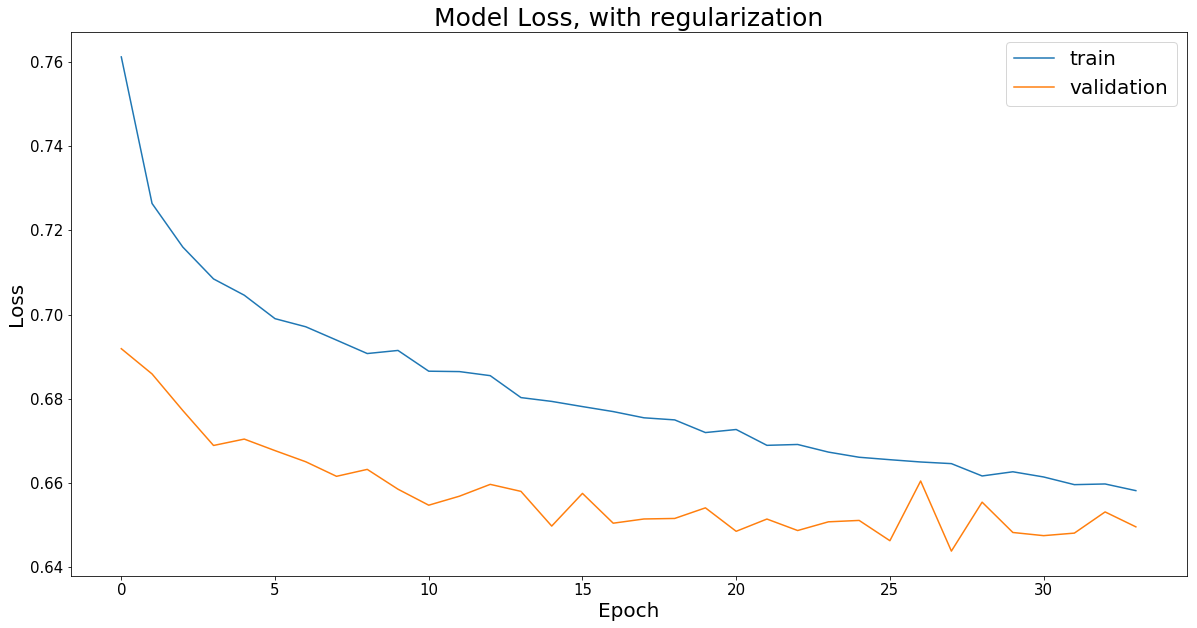

In [145]:
# Visualize the training and validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(size=15)
plt.ylabel('Loss', size=20)
plt.xticks(size=15)
plt.xlabel('Epoch', size=20)
plt.legend(['train', 'validation'], loc='upper right', fontsize=20)
plt.title('Model Loss, with regularization', size=25)
plt.show()

With regularization there no overfitting. However, the train loss decreases constantly while the validation loss doesn't show improvement after epoch 15.

### Transfer learning evaluation metrics values

In [21]:
from keras.models import load_model

model = load_model('./saved_models/weights.best.CNN_arch_VGG19.hdf5')

In [22]:
# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(feature, axis=0)))) \
               for feature in bottleneck_features_test]

In [23]:
# report test accuracy
test_accuracy = np.sum(np.array(predictions)==labels[idx_test])/len(predictions)
print('Test accuracy: %.4f%%' %(100*test_accuracy))

Test accuracy: 80.6271%


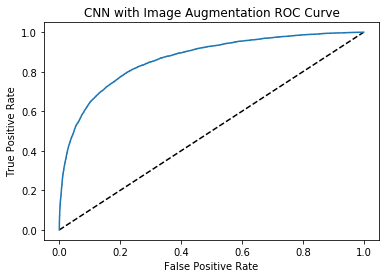

Area under ROC: 0.8664
Precision for 0 and 1: 88.69% and 64.10%
Recall for 0 and 1: 83.51% and 73.43%
F1 score for 0 and 1: 86.02% and 68.45%
Confusion matrix:
 [[16407  3239]
 [ 2093  5784]]


In [25]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_test = labels[idx_test]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(feature, axis=0))) \
               for feature in bottleneck_features_test]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_roc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN with Image Augmentation ROC Curve')
plt.show()

print("Area under ROC: {:.4f}".format(auc_roc))
print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

Using transfer learning, the best obtained accuracy is 80.6271% and the best F<sub>1</sub> on the 0 labels is 86.02%. For the the positive labels F<sub>1</sub> is 68.45%.

This is better than the benchmark model. If all the weights from the VGG19 are trained from scratch, it is expected to get better results. But that task is too heavy for a home laptop. So, instead it can be worth to try to do better by defining our own CNN architecture.

## Custom made CNN architecture

The architecture is composed of 3 convolutional layers, a flattened layer, two dense layers and the output layer. The first 4 layers have first a convolutional layer with a kernel of 3x3 pixels. 3x3 was chosen given that this was used in the VGG architecture with good results. The 3x3 pooling window at each of the first 3 layers is also inspired from VGG. VGG uses 2x2 but 3x3 runs faster, so it slightly increases the training speed. Laos I consider that it should be a good practice to have a pooling window of the same size as the convolutional window. The activation function chosen for the convolutional layers is 'relu' and the dropout sub-layer for each convolutional layer is inspired from [AlexNet](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf). The purpose of the dropout is to avoid overfitting and to introduce regularization.

The input layer shape is based on the input images sizes (50x50x3). From layers 1 to 3, the number of filters progresses as follows: 32, 64, 128. When dealing with algorithms I feel comfortable moving by factors of 2. For all the 3 CNN layers the padding was set as 'same' to keep the filter sizes as the size of the inputs to each layer.

For the third layer, its output is flatten before going to the denses layer.s So, a flattening layer was used for this purpose.

The output layer, which is a dense layer, has a size of 1 corresponding to the probability of getting a label of 1. The the 'sigmoid' activation function was chosen because it is output range is $[0, 1]$.

In [153]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Architecture
# Layer 1 : input layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', \
                activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

#model.add(GlobalAveragePooling2D('channels_last'))

#Flat layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         73856     
__________

In [154]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
Train the model:

In [155]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

epochs = 100
batch_size = 512

stopping_condition = EarlyStopping(patience=6)
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.CNN_arch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(images[idx_train], labels[idx_train], \
          validation_split=0.1, \
          epochs=epochs, batch_size=batch_size, class_weight={0:1, 1:2.5},\
          callbacks=[checkpointer, stopping_condition], verbose=1)

Train on 222929 samples, validate on 24770 samples
Epoch 1/100
222929/222929 [==============================] - 15s 65us/step - loss: 0.7051 - acc: 0.7785 - val_loss: 0.7714 - val_acc: 0.6437

Epoch 00001: val_loss improved from inf to 0.77135, saving model to ./saved_models/weights.best.CNN_arch.hdf5
Epoch 2/100
222929/222929 [==============================] - 14s 62us/step - loss: 0.6330 - acc: 0.8072 - val_loss: 0.6956 - val_acc: 0.7062

Epoch 00002: val_loss improved from 0.77135 to 0.69556, saving model to ./saved_models/weights.best.CNN_arch.hdf5
Epoch 3/100
222929/222929 [==============================] - 14s 62us/step - loss: 0.6082 - acc: 0.8152 - val_loss: 0.6900 - val_acc: 0.7011

Epoch 00003: val_loss improved from 0.69556 to 0.68996, saving model to ./saved_models/weights.best.CNN_arch.hdf5
Epoch 4/100
222929/222929 [==============================] - 14s 62us/step - loss: 0.5835 - acc: 0.8234 - val_loss: 0.7422 - val_acc: 0.6383

Epoch 00004: val_loss did not improve from 

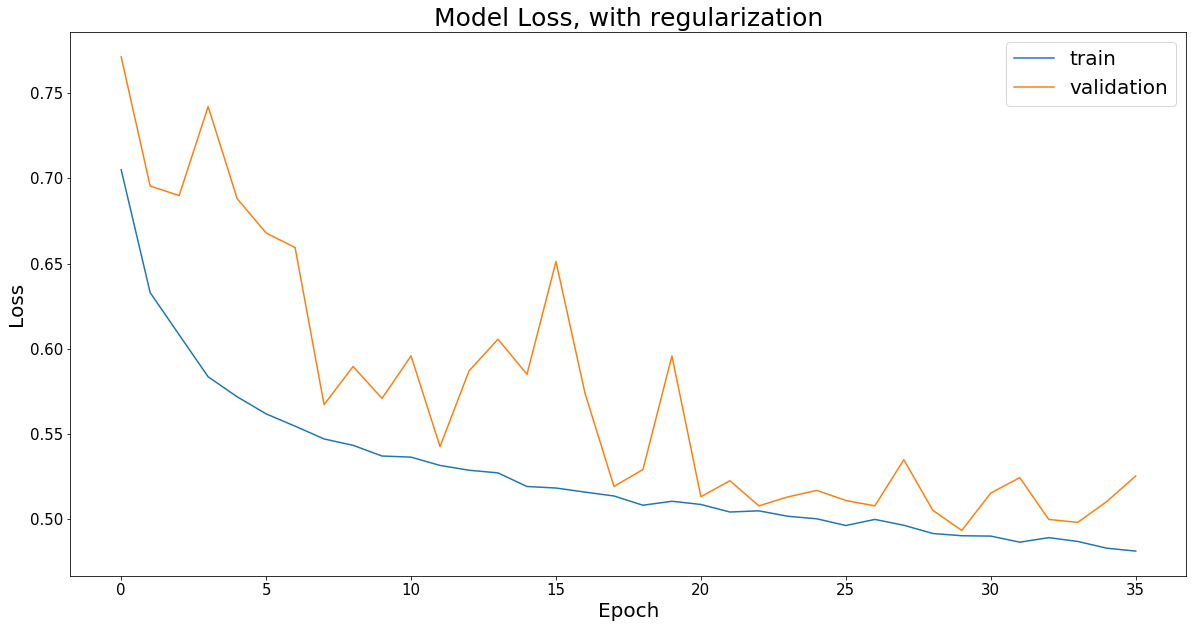

In [157]:
# Visualize the training and validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(size=15)
plt.ylabel('Loss', size=20)
plt.xticks(size=15)
plt.xlabel('Epoch', size=20)
plt.legend(['train', 'validation'], loc='upper right', fontsize=20)
plt.title('Model Loss, with regularization', size=25)
plt.show()

The custom architecture obtains better losses than the transfer learning model. The validation loss tends to present high jumps during training but approaches the training loss as the number of epochs increases.

### Custom CNN evaluation metrics values

Load model with best validation loss:

In [26]:
model = load_model('./saved_models/weights.best.CNN_arch.hdf5')

Test model in validation set:

In [27]:
# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(image, axis=0)))) \
               for image in images[idx_test]]

In [28]:
# report test accuracy
test_accuracy = np.sum(np.array(predictions)==labels[idx_test])/len(predictions)
print('Test accuracy: %.4f%%' %(100*test_accuracy))

Test accuracy: 84.9726%


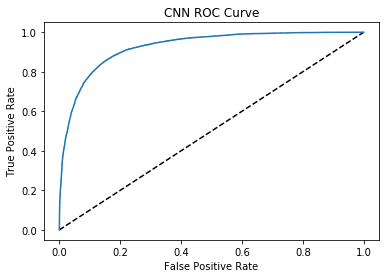

Area under ROC: 0.9263
Precision for 0 and 1: 93.63% and 69.19%
Recall for 0 and 1: 84.71% and 85.63%
F1 score for 0 and 1: 88.95% and 76.53%
Confusion matrix:
 [[16642  3004]
 [ 1132  6745]]


In [29]:
y_test = labels[idx_test]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(image, axis=0))) \
               for image in images[idx_test]]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_roc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.show()

print("Area under ROC: {:.4f}".format(auc_roc))
print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

The custom CNN network resuls in an accuracy of 84.9726% and an F<sub>1</sub> score in  healthy images (class 0) of 88.95%. For the IDC images (label 1) the  obtained F<sub>1</sub> is 76.53%.

This is better than the transfer learning model using VGG19. Now given that we know that the classes are unbalanced, let's train a similar architecture by performing image augmention.

## Custom architecture with image augmentation

Image augmentation increases the number of avalaible images by applying random rotations, shifts and flips to the existing images to generate new ones. 

In [162]:
from keras.preprocessing.image import ImageDataGenerator

# Create and configure image generator
data_gen_train = ImageDataGenerator(rotation_range=90.0, \
                                    width_shift_range=0.2, \
                                    height_shift_range=0.2, \
                                    horizontal_flip=True)

# Fit image generator to data
data_gen_train.fit(images[idx_train])

Given that augmented data is used, this time the method [fit_generator](https://keras.io/models/model/#fit_generator) is used. For fit_generator the validation data needs to be specified directly. It cannot represent a percentage of the training input. Then we divide the training data into a train and validation sets.

In [163]:
idx_train_2, idx_val = train_test_split(np.arange(idx_train.shape[0]), test_size=0.1, \
                                      random_state=seed, shuffle=True, stratify=labels[idx_train])

Same architecture as before:

In [164]:
model = Sequential()

### Architecture
# Layer 1 : input layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', \
                activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

#model.add(GlobalAveragePooling2D('channels_last'))

#Flat layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 128)         73856     
__________

In [165]:
epochs = 100
batch_size = 256

stopping_condition = EarlyStopping(patience=6)
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.CNN_arch_augmented.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(data_gen_train.flow(images[idx_train_2], labels[idx_train_2], \
                                   batch_size=batch_size), \
                    validation_data=(images[idx_val], labels[idx_val]), \
                    steps_per_epoch=len(idx_train_2)//batch_size, \
                    epochs=epochs, class_weight={0:1, 1:2.5},\
                    callbacks=[checkpointer, stopping_condition], verbose=1)

Epoch 1/100
870/870 [==============================] - 146s 168ms/step - loss: 0.7010 - acc: 0.7799 - val_loss: 0.4798 - val_acc: 0.7914

Epoch 00001: val_loss improved from inf to 0.47978, saving model to ./saved_models/weights.best.CNN_arch_augmented.hdf5
Epoch 2/100
870/870 [==============================] - 143s 164ms/step - loss: 0.6222 - acc: 0.8095 - val_loss: 0.5142 - val_acc: 0.7533

Epoch 00002: val_loss did not improve from 0.47978
Epoch 3/100
870/870 [==============================] - 145s 167ms/step - loss: 0.5984 - acc: 0.8188 - val_loss: 0.5968 - val_acc: 0.7031

Epoch 00003: val_loss did not improve from 0.47978
Epoch 4/100
870/870 [==============================] - 144s 165ms/step - loss: 0.5821 - acc: 0.8245 - val_loss: 0.4705 - val_acc: 0.7918

Epoch 00004: val_loss improved from 0.47978 to 0.47052, saving model to ./saved_models/weights.best.CNN_arch_augmented.hdf5
Epoch 5/100
870/870 [==============================] - 139s 160ms/step - loss: 0.5728 - acc: 0.8276 - 

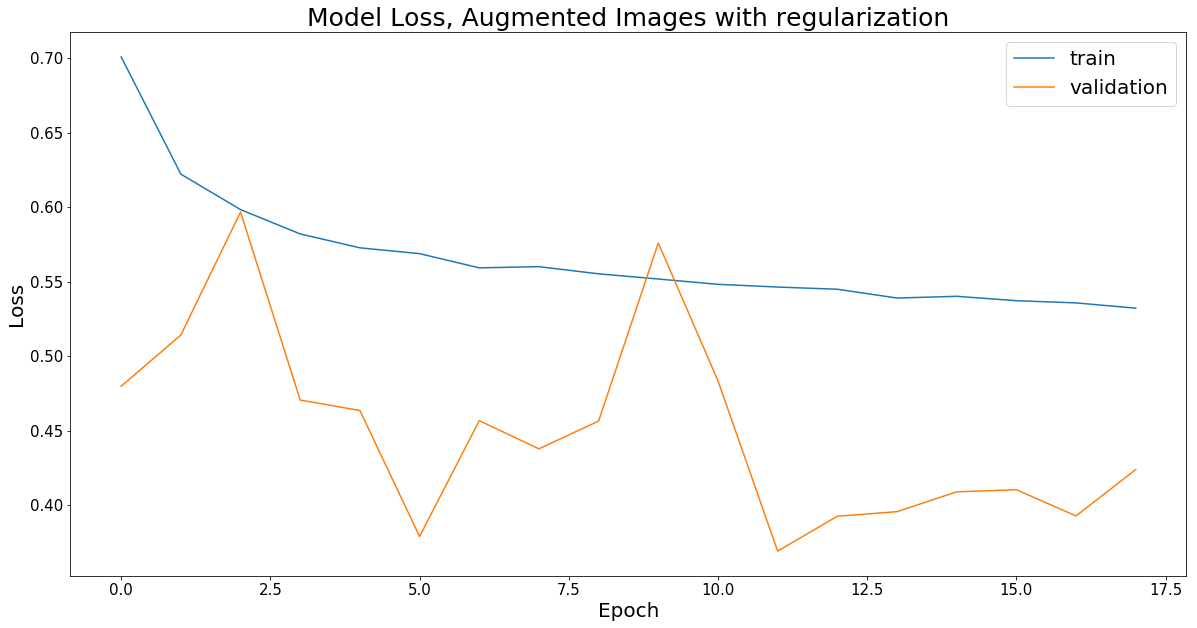

In [166]:
# Visualize the training and validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(size=15)
plt.ylabel('Loss', size=20)
plt.xticks(size=15)
plt.xlabel('Epoch', size=20)
plt.legend(['train', 'validation'], loc='upper right', fontsize=20)
plt.title('Model Loss, Augmented Images with regularization', size=25)
plt.show()

The plot belows shows that introducing image augmentation for this data set doesn't give any advantage. The training is slower and the train loss is no better than without augmentation and the validation loss doesn't seem to stabilize.

###  Custom CNN with imge augmentation evaluation metrics

In [167]:
model.load_weights('./saved_models/weights.best.CNN_arch_augmented.hdf5')

In [168]:
# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(image, axis=0)))) \
               for image in images[idx_test]]

In [169]:
# report test accuracy
test_accuracy = np.sum(np.array(predictions)==labels[idx_test])/len(predictions)
print('Test accuracy: %.4f%%' %(100*test_accuracy))

Test accuracy: 84.5220%


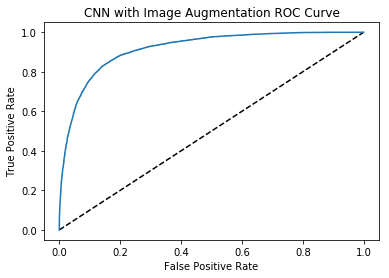

Area under ROC: 0.9166
Precision for 0 and 1: 92.88% and 68.88%
Recall for 0 and 1: 84.82% and 83.78%
F1 score for 0 and 1: 88.67% and 75.60%
Confusion matrix:
 [[16664  2982]
 [ 1278  6599]]


In [171]:
y_test = labels[idx_test]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(image, axis=0))) \
               for image in images[idx_test]]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_roc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN with Image Augmentation ROC Curve')
plt.show()

print("Area under ROC: {:.4f}".format(auc_roc))
print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

The custom CNN network using image augmentation resulted in an accuracy of 84.5220% and an F<sub>1</sub> score in the healthy images (class 0) of 88.67%. For the IDC images (label 1) the  F<sub>1</sub> was 75.60%.

# Results

The table below summarizes the results for each model considered in this project.

| Model             | Accuracy   | F<sub>1</sub> score (labels 0) | F<sub>1</sub> score (labels 1) |
|  ---              |    ---     |         ---         |   ---  |
| Benchmark naive model | 71.38% |   83.30             |    -   |
| Pre-trained VGG19 |   80.6271% |   86.02%            | 68.45% |
| Custom CNN        |   84.9726% |   88.95%            | 76.53% |
| Custom CNN with image augmentation | 84.5220% | 88.67%|  75.60%

As the table shows, the custom CNN has the better metrics. The custom CNN with image augmentation behaves similarly however its training time is too slow. Interestingly, the pre-trained model didn't behave as well compared to the best models. This is certainly due to the fact that the histopathology images are tottaly different to those used in ImageNet.

Import custom CNN:

In [11]:
from keras.models import load_model

model = load_model('./saved_models/weights.best.CNN_arch.hdf5')

Let's plot again the ROC curve for the custom CNN:

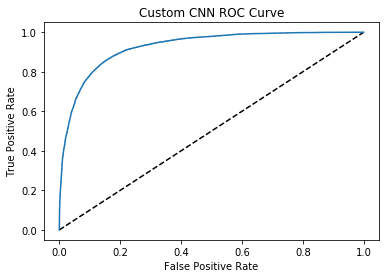

Area under ROC: 0.9263
Precision for 0 and 1: 93.63% and 69.19%
Recall for 0 and 1: 84.71% and 85.63%
F1 score for 0 and 1: 88.95% and 76.53%
Confusion matrix:
 [[16642  3004]
 [ 1132  6745]]


In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc

# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(image, axis=0)))) \
               for image in images[idx_test]]

y_test = labels[idx_test]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(image, axis=0))) \
               for image in images[idx_test]]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_roc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Custom CNN ROC Curve')
plt.show()

print("Area under ROC: {:.4f}".format(auc_roc))
print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

The false positive rate (FPR) can be improved by changing the threshold on the predictions. For example if the goal is to have a false positive rate smaller than 1%, then the threshold to classify an image as an IDC image must be:

In [16]:
# Find index for 1% threshold
thresh = 0.01
idx_1per = list(fpr).index(max([i for i in fpr if i < thresh]))
print("Threshold to ensure FPR is smaller than 1%%: %.4f" %thresholds[idx_1per])

Threshold to ensure FPR is smaller than 1%: 0.9474


Predicitions and metrics using new threshold:

In [17]:
# Predictions with new threshold
predictions_1per = np.array(y_pred_prob >= thresholds[idx_1per])

# Metrics
confusion = confusion_matrix(y_test, predictions_1per)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predictions_1per, beta=1)

accuracy = np.sum(np.array(predictions_1per)==labels[idx_test])/len(idx_test)

print("Accuracy: {:.2f}%%".format(accuracy*100))
print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

Accuracy: 80.69%%
Precision for 0 and 1: 79.16% and 93.36%
Recall for 0 and 1: 99.00% and 35.01%
F1 score for 0 and 1: 87.98% and 50.93%
Confusion matrix:
 [[19450   196]
 [ 5119  2758]]


The new threshold increases the precision to 93.96% but decreases accuracy to 80.69%. Similarly it decreases the recall value for positive classes, indicating that adjusting the threshold for a higher precision also increases the false negative rate. This is confirmed by the confusion matrix.


Let's now check some of the image predictions by the custom CNN with the sklearn standard threshold.

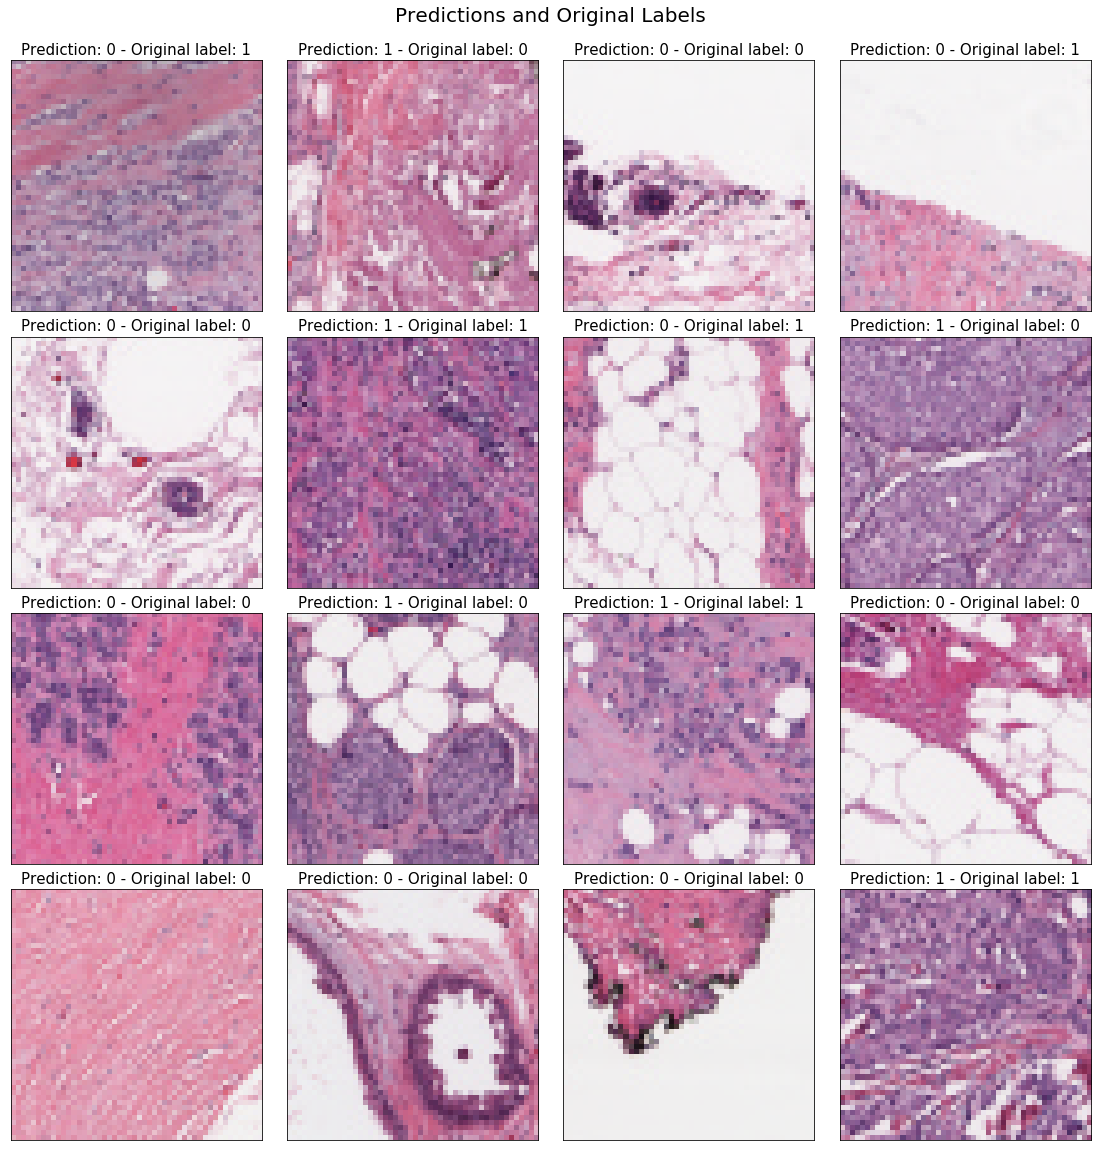

In [295]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)
for i in range(4, 20):
    ax = fig.add_subplot(4, 4, i - 3, xticks=[], yticks=[])
    ax.imshow(images[idx_test[i]])
    _ = plt.title("Prediction: {} - Original label: {}".format(predictions[i], labels[idx_test[i]]), \
             size=15)
_ = plt.suptitle("Predictions and Original Labels", size = 20, y=1.05)

Let's visualize separately the properly classified images and the misclassified images.

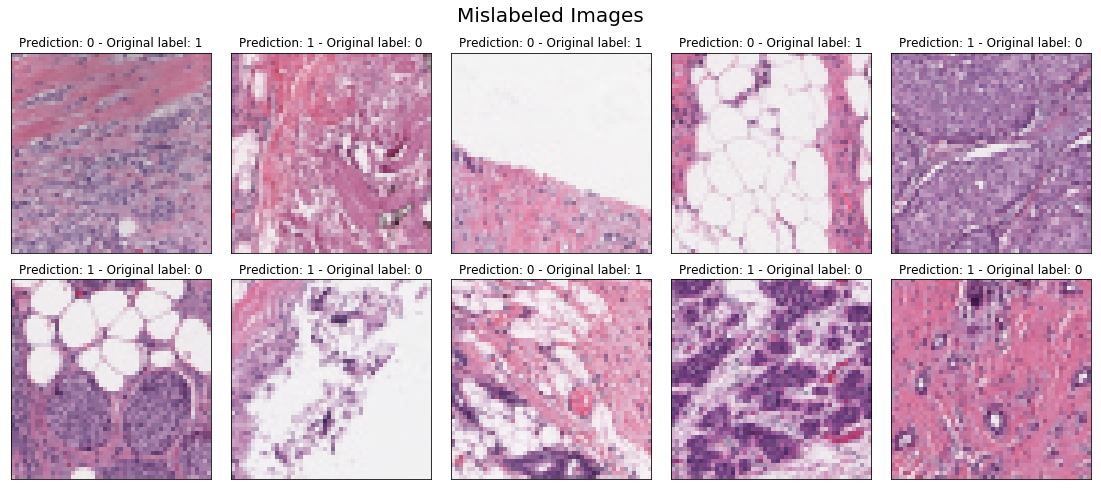

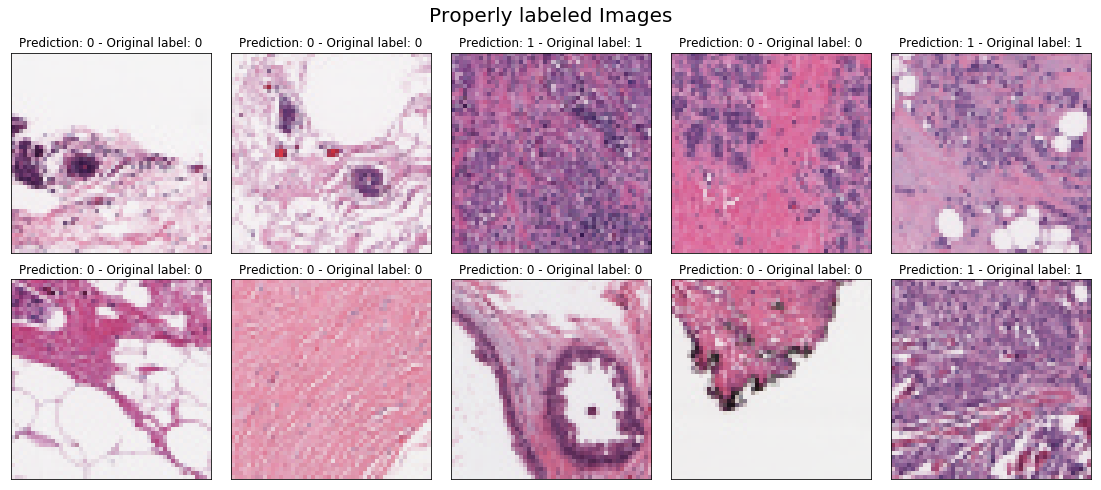

In [294]:
# Display mislabeled images
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)
j = 1
for i in range(4, 41):
    if predictions[i] != labels[idx_test[i]]:
        ax = fig.add_subplot(2, 5, j, xticks=[], yticks=[])
        ax.imshow(images[idx_test[i]])
        _ = plt.title("Prediction: {} - Original label: {}".format(predictions[i], labels[idx_test[i]]), \
                 size=12)
        j += 1
_ = plt.suptitle("Mislabeled Images", size = 20, y=1.1)
# Display correctly labeled images
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)
j = 1
for i in range(4, 20):
    if predictions[i] == labels[idx_test[i]]:
        ax = fig.add_subplot(2, 5, j, xticks=[], yticks=[])
        ax.imshow(images[idx_test[i]])
        _ = plt.title("Prediction: {} - Original label: {}".format(predictions[i], labels[idx_test[i]]), \
                 size=12)
        j += 1
_ = plt.suptitle("Properly labeled Images", size = 20, y=1.1)

On the misclassified images it is difficult to visually determine why the algorithm failed. However, it seems that the model gives more weight to the violet tones than to the structure to labeled an image as being IDC. Similarly it seems that the algorithm considers that images with a lot of white areas and clear tones of violet to be an indication of a healthy tissue.

# Conclusion

A model to classify images from and unbalanced data set was proposed. Given the imbalance, accuracy it is not the only metric of interest. The F<sub>1</sub> score also needs to be considered. For this particular problem, where it is important to accurately identify IDC regions (positive classes), precision is also a metric of choice.

If precision is very important for a user of this model, in order to improve this metric the threshold to classify an image as presenting IDC can be adjusted. Given that increasing the precision also increases the false negative rate (FNR), the user needs to consider the most appropriate balance between a high precision and the FNR. Also, given that the output of the model is the probability for an image of being from an IDC region, the histopathologist can define a range between 0 and 1 to choose which images need to be visually analyzed. 

When developing the model it was found that transfer learning didn't perform as well as expected with the VGG19 architecture. This can be explained by the fact that the original weights from VGG19 are calculated using images from [ImageNet](http://www.image-net.org/). ImageNet is an image data base consisting  of 1000 categories of common objects and animals, and the histhopathology images used in this project are totally different. This explains the performance of the transfer learning model. Surely a full training of the VGG19 architecture using the histopathology images will provide a more reliable classifier.

The best results were obtained implementing a simple architecture using what is known to work properly in different famous CNN architectures. It is accepted that in most cases image aumentation tends to improve a model. However, for this particular data set it was not the case. In the present situation image augmentation just turned training into a very slow task with no gain. So, it seems that for this kind of images image augmentation should be avoided.

A quick analysis of the predictions in the validation data tends to hint that the model considers tones of violet and image structure to assign the probability of an image to be of cancerous tissue. Most likely a higher accuracy was not obtained given that, as noted in this [paper](https://www.ncbi.nlm.nih.gov/pubmed/27563488), not all the IDC regions in the original image slides were fully indicated by the hysthopathologist. As noted at the beginning this is a very time consumming and arduous task, thus the interest on developing this kind of classifiers for the medical sciences.